# LOG6308 : Tp1 - Recommendation by collaboratif filtering 

- Clément Bernard (2096223)
- Ghaith Dekhili ()

## Importations 

In [1579]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import time
from sklearn.cluster import KMeans

## Data 

In [1580]:
# The path where is the fold data
PATH_DATA = 'data'

In [1581]:
# The items 
items = pd.read_csv(os.path.join(PATH_DATA, 'items.csv'), sep='|')
# User data 
u = pd.read_csv(os.path.join(PATH_DATA, 'u.csv'), sep='|')
# Votes of the user 
votes = pd.read_csv(os.path.join(PATH_DATA, 'votes.csv'), sep='|')

In [1582]:
items

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1583]:
u

,id,age,gender,job,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [1584]:
votes

,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


## Creation of sparse matrix : User-item matrix

In [1585]:
# The number of users 
N_USERS = u.shape[0] +1
# The number of items 
N_ITEMS = items.shape[0] +1 

In [1586]:
def create_sparse_matrix(votes) : 
    ''' Create a User-Items sparse matrix '''
    # Create NaN for each items and users 
    data = {i : [np.nan for j in range(N_USERS )] for i in range(N_ITEMS)}
    def to_convert(x, data) :
        data[x['item.id']][x['user.id']] = x['rating']
        return None 
    votes.apply(to_convert , axis = 1 , args = [data])
    return pd.DataFrame(data)

In [1587]:
user_item = create_sparse_matrix(votes)

In [1588]:
# We drop the first user who has no grades
user_item= user_item.iloc[1:,1:]

In [1589]:
user_item

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question 1 

- Tout d'abord, nous creons les indexes qui vont permettre de diviser nos données pour la cross-validation

In [1590]:
def kfold(n_data, k = 10 , SEED = 77, shuffle = False ) : 
    ''' Split the data into K-Folds 
        Input : The length of the data to split 
        Output : The indexes of the different folds 
    '''
    # Fix the SEED to have consistent results 
    np.random.seed(SEED)
    # Create the indexes 
    indexes = np.arange(n_data)
    # Shuffle the matrix 
    if shuffle : 
        np.random.shuffle(indexes)
    # The size of the subindexes
    sub_size = n_data // k 
    # Size of the last fold used for the test 
    last_size = sub_size + n_data%k
    # Where we store all the indexes 
    all_indexes = {'train' : [], 'test' : []}
    # Index of the test 
    test_i = 0 
    for i in range(k) :
        train = []
        # Check if we are the last set 
        if test_i == k-1 : 
            all_indexes['test'].append(indexes[-last_size:])
            all_indexes['train'].append(indexes[:-last_size ])
        else : 
            all_indexes['test'].append(indexes[ test_i * sub_size : (test_i+1) * sub_size ])
            # Get the indexes outside the test indexes
            train = [] 
            train.extend(indexes[:test_i * sub_size])
            train.extend(indexes[(test_i+1) * sub_size : ])
            all_indexes['train'].append(train)
        
        
        test_i +=1 
        
    return all_indexes


- Maintenant, nous implémentons les fonctions pour calculer les valeurs moyennes des utilisateurs et items 

In [1591]:
def average_user(user_item) : 
    ''' Compute the average score for the users '''
    # Compute the mean for the users 
    return user_item.apply( lambda x : np.mean(x) , axis = 1 )
    
def average_item(user_item) : 
    ''' Compute the average score for the items '''
    # Compute the mean for the items 
    return user_item.apply( lambda x : np.mean(x) , axis = 0 )

- Ensuite, nous remplissons les valeurs manquantes de la matrice avec les valeurs moyennes utilisateurs et items

In [1592]:
def fill_avg(indexes = None  , user_item = user_item ) : 
    ''' Fill the user_item matrix with the mean of users and items 
        It fills only the indexes values 
    '''
    # Average grade by user 
    avg_user = average_user(user_item)
    # Average grade by item
    avg_item = average_item(user_item)
    # Repeat the average of users
    avg_user_all = pd.DataFrame(np.tile(avg_user.values, (N_ITEMS-1,1)))
    # Repeat the average of items 
    avg_item_all = pd.DataFrame(np.tile(avg_item.values, (N_USERS-1,1)))
    # Get the average of users and items
    new_user_item = (avg_user_all.fillna(0).T + avg_item_all.fillna(0))/2
    # Change the indexes
    new_user_item = new_user_item.set_index([pd.Index(np.arange(1,N_USERS))])
    # Change the colums 
    new_user_item.rename(columns = {i : i+1 for i in range(N_ITEMS-1)}, inplace = True )
    # Get the original matrix
    new_user = user_item.copy()
    # Fill it 
    if indexes is None : 
        return new_user_item 
    new_user[indexes] = new_user_item[indexes]
    return new_user

- Utilisation de cross-validation pour calculer l'erreur 

In [1593]:
def cross_validation(N ,k , votes = votes , user_item = user_item) : 
    ''' Compute the quadratic error with K-cross-validation
        Inputs : 
            - N : The size of the data to split (either size of items or users)
    '''
    # Errors for every user 
    errors = np.zeros((user_item.shape[0],1))
    # Real user_item matrix
    user_item_true = user_item.copy()
    # Get the indexes where there are not NaN values 
    indexes_not_nan = user_item.notnull()
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = False ).values())) : 
        # Copy the original user-item matrix 
        u_item = user_item.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:3]
        # Convert the test rating to NaN
        for m,j in zip(indexes_test['user.id'].values, indexes_test['item.id'].values) :            
            u_item.iloc[m-1,j-1] = np.nan
        # Get the prediction
        prediction = fill_avg(indexes_not_nan, u_item)
        # Compute the RMSE 
        current_e = np.sqrt(np.mean((user_item_true[indexes_not_nan] -\
                                    prediction[indexes_not_nan])**2, axis = 1))
        errors= errors + current_e.values.reshape(-1,1)
    errors/=k        
    return pd.DataFrame(errors)
    

In [1594]:
error_user = cross_validation( N = votes.shape[0] ,k = 10  )

Text(0, 0.5, 'Number of values')

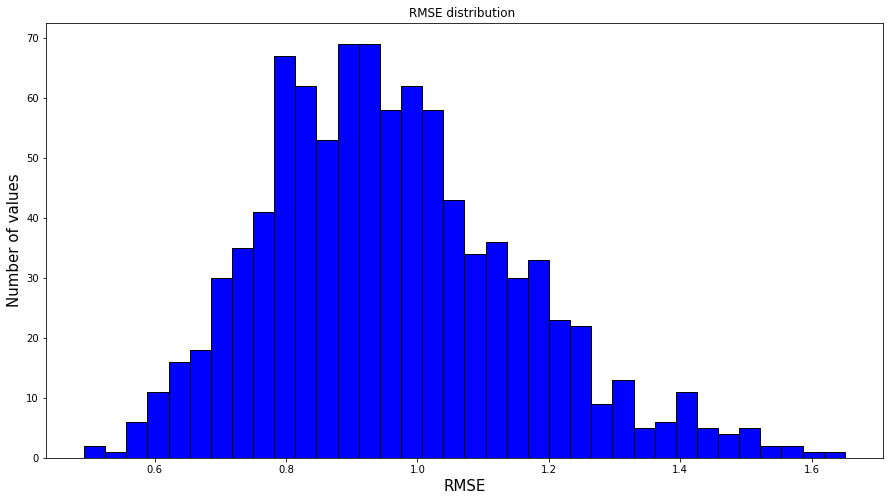

In [1595]:
plt.figure(figsize=(15,8))
rmse = error_user.values.flatten()
plt.hist(rmse, color = 'blue', edgecolor = 'black', bins = int(180/5), log=False)
# Add labels
plt.title('RMSE distribution ')
plt.xlabel('RMSE',fontsize=15)
plt.ylabel('Number of values',fontsize=15)

In [1596]:
print("RMSE pour l'approche par vote moyen : {} ".format(np.mean(error_user.values)))

RMSE pour l'approche par vote moyen : 0.9600237455440639 


## Conclusion Question 1 : 

- Nous voyons que l'approche par remplissage des moyennes utilisateurs-items est une approche naïve qui performe moyennement bien. Cela reste mieux que de remplir par un score aléatoire. On s'attend néanmoins à avoir un meilleur score pour les méthodes suivantes

## Question 2 

### 2.a Distribution (histogramme) des similarités (poids w )

In [1597]:
item_item = user_item.T.copy()

In [1598]:
def get_similarity_matrix(item_item, size = N_ITEMS) : 
    ''' Return a dataframe of size : N_ITEM x N_ITEM with the similarity for each user 
            within the other items '''
    df_sim = pd.DataFrame(cosine_similarity(item_item.fillna(0), item_item.fillna(0)))
    return df_sim

In [1600]:
initial_time = time.time()
def_sim = get_similarity_matrix(item_item)
print('Time required : {} s'.format(time.time()-initial_time))

Time required : 0.10363221168518066 s


In [1604]:
def return_similarities_distribution(def_sim):
    """
    return similarities distribution
    """
    plt.figure(figsize=(15,8))
    similarities_distribution = def_sim.values.flatten()
    plt.hist(similarities_distribution, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)

    # Add labels
    plt.title('Similarities distribution')
    plt.xlabel('Similarity',fontsize=15)
    plt.ylabel('Number of values',fontsize=15)
    return similarities_distribution

- Voici ici la distribution des similarités par item 

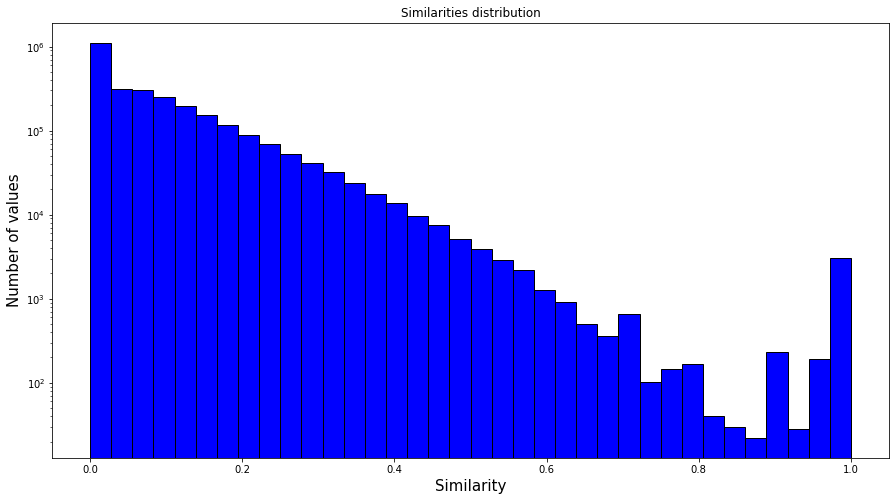

In [1605]:
similarities_distribution = return_similarities_distribution(def_sim)

- On remarque qu'une bonne partie de la similarité des items se trouvent entre 0 et 0.2. Cela signifie que certains items sont assez similaires et donc peuvent permettre d'approximer correctement un item en prenant les voisins de celui-ci.
- La similarité de 1 correspond à la similarité d'un item avec lui même. 

### La proportion de poids nuls

In [1620]:
def print_zeros_weights_proportion(df):
    """
    prints proportion of zeros among all similarities values
    """
    numZeros = (def_sim == 0).sum().sum()/ def_sim.size
    print("proportion of zero weights = {}".format(numZeros))

In [1621]:
print_zeros_weighs_proportion(def_sim)

proportion of zero weights =  0.3043450905651361


- On remarque que près de 30 % de la matrice est à poids nul. Cela signifique que un peu moins de 1/3 des items ne sont pas corrélés entre eux

### 2.b   Distribution du nombre de voisins avec votes communs par item

In [1625]:
def buil_neighbors_indexes(item_item):
    """
    Returns a df with items and their neighbors with similarities and a df with neighbors' indexes 
    """
    #A df for items and their neighbors with similarities
    df_10_neighbors = pd.DataFrame(np.zeros((N_ITEMS, 10)), index = range(1,N_ITEMS+1))  
    #A df for items with their neighbors' indexes 
    df_10_index = pd.DataFrame(np.zeros((N_ITEMS, 10)), index = range(1,N_ITEMS+1))                            
    #count = 0
    for i in range(len(item_item)):
        mySeries = def_sim.iloc[i].copy()    
        for n in range(10):
            max_val = mySeries.values.max()
            max_idx = pd.Index(mySeries).get_loc(max_val)
            
            #we don't take the actual item as neighbor of itself
            if type(max_idx) is int and max_idx == i:
                mySeries = mySeries.drop(mySeries.index[max_idx])
                max_val = mySeries.values.max()
                max_idx = pd.Index(mySeries).get_loc(max_val)
            
            #There are some max with a list of boolean as index, so we don't take them
            while type(max_idx) is not int:
                #count +=1
                mySeries = mySeries.drop(mySeries.index[max_idx])
                max_val = mySeries.values.max()
                max_idx = pd.Index(mySeries).get_loc(max_val)            
            
            df_10_neighbors.iloc[i,n] =  max_val
            #in the next line we add 1 as our items index start with 1  
            df_10_index.iloc[i,n] = int(max_idx+1)
            mySeries = mySeries.drop(mySeries.index[max_idx])
    return df_10_neighbors, df_10_index

In [1626]:
df_10_neighbors_sim,df_10_index = buil_neighbors_indexes(item_item)

- Matrice avec les 10 voisins ainsi que leur score de similarité

In [43]:
df_10_neighbors_sim.head()

,0,1,2,3,4,5,6,7,8,9
1,0.734572,0.699925,0.689786,0.664555,0.641322,0.638158,0.636727,0.630601,0.624075,0.622382
2,0.659619,0.623544,0.617274,0.616143,0.604969,0.601960,0.597083,0.595684,0.590124,0.584100
3,0.452023,0.444355,0.423249,0.404930,0.404787,0.404239,0.404080,0.401676,0.397274,0.396868
4,0.650507,0.628946,0.628720,0.620055,0.617312,0.604652,0.602747,0.601488,0.601319,0.599989
5,0.547787,0.472725,0.472399,0.450780,0.445242,0.440996,0.435349,0.430292,0.425298,0.424652


- Matrice avec les 10 voisins ainsi que leur index

In [1627]:
df_10_index.head()

,0,1,2,3,4,5,6,7,8,9
1,49.0,179.0,119.0,115.0,400.0,147.0,216.0,98.0,229.0,168.0
2,232.0,160.0,382.0,399.0,61.0,570.0,223.0,227.0,542.0,94.0
3,409.0,761.0,41.0,32.0,247.0,16.0,1040.0,818.0,469.0,231.0
4,55.0,202.0,172.0,199.0,94.0,191.0,169.0,208.0,77.0,375.0
5,217.0,217.0,53.0,230.0,52.0,95.0,665.0,196.0,657.0,551.0


#### Proportion de votes manquants

- Tout d'abord, on  centre la matrice item-item en retirant la moyenne 

In [1630]:
def centre_df(user_item):
    """
    Create a df with centered votes of user_item
    """
    user_item_centred = user_item.add(-user_item.mean())
    
    return user_item_centred

In [1631]:
user_item_centred = centre_df(user_item)

- On construit un matrice des utilisateurs avec 10 voisins de cette item (matrice V de la vidéo)

In [1653]:
def build_users_items_neigh_mtx(df_10_index_i,user_item):
    """
    builds an item votes matrix of users with 10 neighbors of this item (V in the video)
    """
    df_10_votes = pd.DataFrame(np.zeros((N_USERS, 10)), index = range(1,N_USERS+1))
                          
    #loop over 10 neighbors indexes of the actual item "i"                            
    for index, value in df_10_index_i.items():
        #fill df with the votes associated to these 10 neighbors
        df_10_votes[index] = user_item[int(value)] 
 
    return df_10_votes

- On peut ensuite calculer la distribution des votes manquant 


In [1670]:
def return_missed_votes_distribution(df_10_index, user_item_centred, df_10_neighbors_sim):
    '''
    return missed votes per item distribution
    '''
    plt.figure(figsize=(15,8))
    missed_votes_distribution = []
    for item in range(1,N_ITEMS):
        #To return a (943,10) df with votes from user_item matrix from the original user_item df
        df_10_votes = build_users_items_neigh_mtx(df_10_index.loc[item],user_item_centred)
        missed_votes_distribution.append(df_10_votes.isna().sum().sum())
 
    plt.hist(missed_votes_distribution, color = 'blue', edgecolor = 'black', bins = int(180/5), log=False)     
    # Add labels
    plt.title('Distribution de votes manquants par item')
    plt.xlabel('Item id',fontsize=15)
    plt.ylabel('Nombre de votes manquants',fontsize=15)
    
    return missed_votes_distribution  

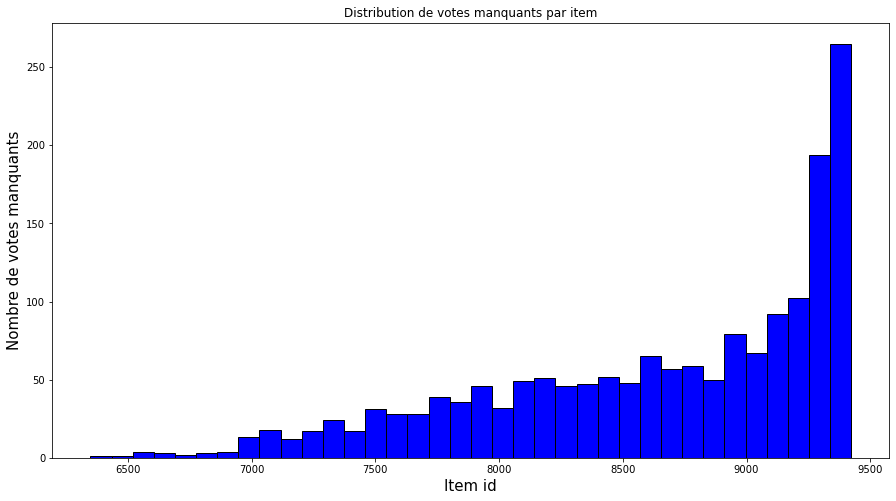

In [1671]:
missed_votes_distribution = return_missed_votes_distribution(df_10_index, user_item_centred, df_10_neighbors_sim)

- On remarque que assez peu d'items ont des votes manquants : seulement ceux d'ids entre 6500 et 9500 

In [1673]:
def return_common_votes_distribution(missed_votes_distribution):
    '''
    return neighbors with common votes per item distribution 
    ''' 
    plt.figure(figsize=(15,8))
    common_votes_distribution = [(N_USERS*10 - n_miss_votes) for n_miss_votes in missed_votes_distribution]
    
    plt.hist(common_votes_distribution, color = 'blue', edgecolor = 'black', bins = int(180/5), log=False)
    # Add labels
    plt.title('Distribution du nombre de voisins avec votes communs par item')
    plt.xlabel('Item id',fontsize=15)
    plt.ylabel('Nombre de voisins avec votes communs',fontsize=15)
    
    return common_votes_distribution

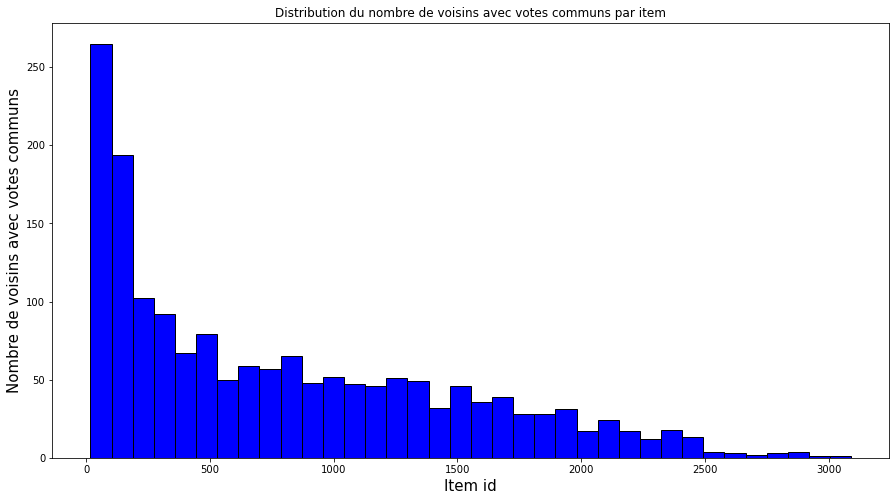

In [1674]:
common_votes_distribution = return_common_votes_distribution(missed_votes_distribution)

#### 2.c Effectuer le calcul pour le premier item 

In [1675]:
def estimate_votes(item, df_10_neighbors_sim, df_10_votes):
    """
    returns 10 neighbors votes given an item
    """
    #get item's 10 neighbors weights wich is W, note that it is the same for all users for a selected item
    item_weights = pd.DataFrame(df_10_neighbors_sim.loc[item])  
    C_df = pd.DataFrame(df_10_votes.copy())
    C_df[~df_10_votes.isnull()==True] = 1
    C_df[~df_10_votes.isnull()==False] = 0
    masked_weights = np.dot(C_df,item_weights)
    df_masked_weights = pd.DataFrame(masked_weights, index = range(1,N_USERS+1))
    K = (1/df_masked_weights.fillna(0)).replace(np.inf,0)
    
    return K*(np.dot(df_10_votes.fillna(0),item_weights))

In [1697]:
def return_first_item_votes(df_10_index, user_item_centred, df_10_neighbors_sim):
    """
    returns votes vector for item 1, note that votes are centered here
    """
    df_10_votes_1 = build_users_items_neigh_mtx(df_10_index.loc[1],user_item_centred)
    estimated_vote = estimate_votes(1,df_10_neighbors_sim, df_10_votes_1)
    return estimated_vote

In [1698]:
first_item_votes_decentered = return_first_item_votes(df_10_index, user_item_centred, df_10_neighbors_sim)

In [1700]:
first_item_votes_centered = first_item_votes_decentered.add(user_item.mean().iloc[0])
# Drop the values outside 1 and 5 
first_item_votes_centered[first_item_votes_centered < 1] = 1
first_item_votes_centered[first_item_votes_centered > 5] = 5


Text(0, 0.5, "Nombre de notes données par l'item 1")

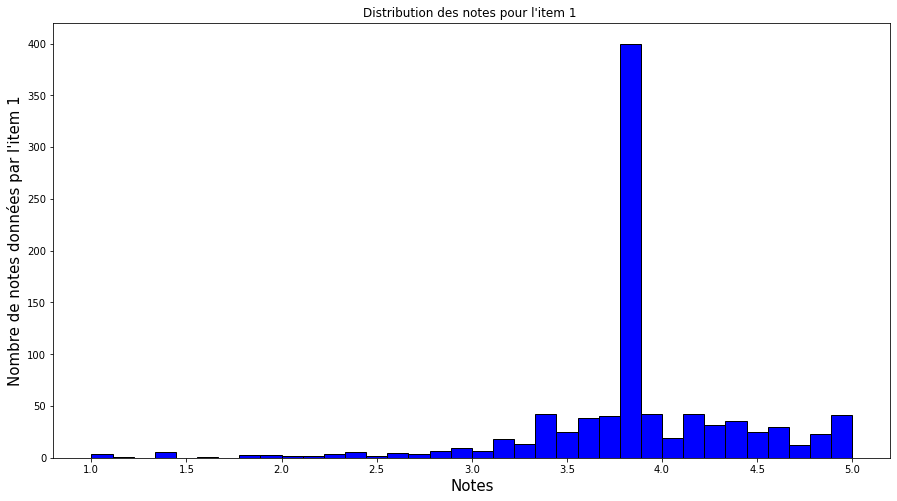

In [1703]:
plt.figure(figsize=(15,8))
    
plt.hist(first_item_votes_centered, color = 'blue', edgecolor = 'black', bins = int(180/5), log=False)
# Add labels
plt.title("Distribution des notes pour l'item 1 ")
plt.xlabel('Notes',fontsize=15)
plt.ylabel("Nombre de notes données par l'item 1" ,fontsize=15)

In [1708]:
print('Moyenne des notes des utilisateurs sur le premier item (méthode de la Q1) : {}'.format(avg_item.iloc[0]))

Moyenne des notes des utilisateurs sur le premier item (méthode de la Q1) : 3.8783185840707963


- On remarque que pour cet item, il y a une majorité de notes entre 3.5 et 4. 
- En prenant le note moyant des utilisateurs pour cet item, cette note est de 3.8. Cela semble bien refléter nos résultats

### 2.d : Erreur quadratique moyenne et histogramme de distribution

In [1727]:
def estimate_all_votes(df_10_index, user_item_centred, df_10_neighbors_sim, user_item = user_item):
    '''
    returns votes for all items
    '''
    es_votes = pd.DataFrame(np.zeros((N_USERS-1, N_ITEMS)), index = range(1,N_USERS), columns = range(1,N_ITEMS+1))
    for item in range(1,N_ITEMS):
        #Return a (943,10) df with votes from user_item matrix from the original user_item df
        df_10_votes = build_users_items_neigh_mtx(df_10_index.loc[item],user_item_centred)
        es_votes[item] = estimate_votes(item, df_10_neighbors_sim, df_10_votes)
    # We add the mean to decenter the votes 
    
    all_estimated_votes_decentred = es_votes.iloc[:,:-1].copy().add(user_item.mean())
    # We scale the votes to be between 1 and 5 
    all_estimated_votes_decentred[all_estimated_votes_decentred< 1 ] = 1
    all_estimated_votes_decentred[all_estimated_votes_decentred > 5 ] = 5
    
    return all_estimated_votes_decentred

- On calcule l'estimation des votes pour tous les items

In [1728]:
# Estimate votes for all items
all_estimated_votes = estimate_all_votes(df_10_index.iloc[:-1,:], user_item_centred, df_10_neighbors_sim)

- Puis on calcule la RMSE 

In [1748]:
def compute_rmse(prediction , user_item = user_item ) : 
    ''' Return the RMSE between the prediction and the user-item matrix '''
    # Index where the user_item is not null
    indexes_not_nan = user_item.notnull()
    rmse = np.sqrt(((prediction[indexes_not_nan] - user_item[indexes_not_nan])**2).mean())
    return rmse

In [1749]:
rmse_estimate = compute_rmse(all_estimated_votes)

In [1750]:
print('RMSE pour la methode Q2 : {}'.format(rmse_estimate.mean()))

RMSE pour la methode Q2 : 0.9006346118047436


Text(0, 0.5, 'y')

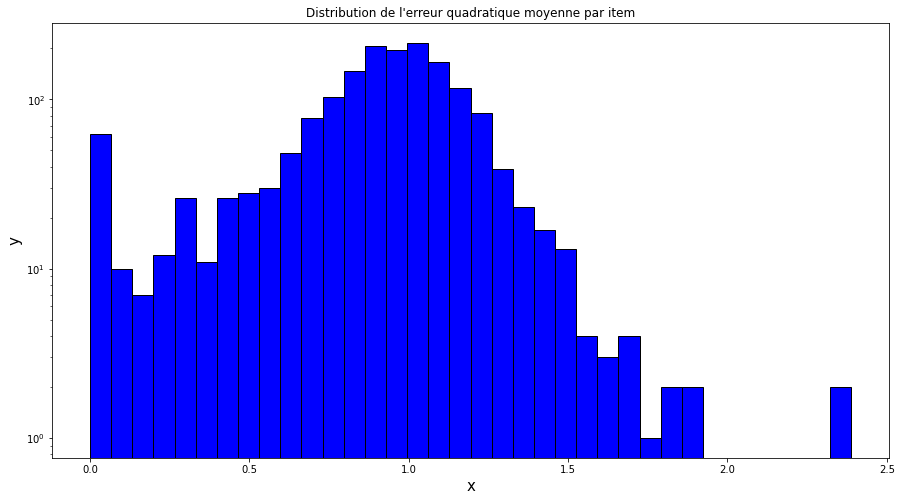

In [1752]:
''' Distribution de l'erreur quadratique moyenne '''
plt.figure(figsize=(15,8))
plt.hist(rmse_estimate, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)
# Add labels
plt.title('Distribution de l\'erreur quadratique moyenne par item')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)

## Conclusion Question 2 : 

- Nous voyons que l'approche item-item avec utilisation des 10 proches voisins est une méthode un peu plus fine que la méthode des moyennes des utilistateurs et items.
- En effet, on obtient une RMSE moyenne de 0.90, qui est mieux que celle de la question 1. 
- Cela peut s'expliquer par le fait que nous considérons les 10 plus proches voisins (avec une similarité cosinus pas forcément la plus précise car ne prend pas en compte le biais des utilisateurs). Ainsi, considérer la moyenne sur les 10 plus proche voisins permet de mieux discerner un item, et c'est ce qu'on retrouve ici. 



## Question 3

- On commence par une fonction qui calcule la SVD

In [1405]:
def svd(N_COMPONENT , user_item  = user_item) : 
    ''' Reduce the dimension with the SVD algorithm '''
    U, s, V = np.linalg.svd(user_item.values, full_matrices=True)
    # Sigma matrix
    S = np.zeros(user_item.shape)
    n_user = user_item.shape[0] 
    # Fill the Sigma matrix with the eigenvalues 
    S[:n_user, :n_user] = np.diag(s)
    # Keep only the N_COMPONENT singular values
    S[N_COMPONENT:, :]  = 0 
    # Reconstruct the original matrix 
    new_user = np.dot(U, np.dot(S,V))
    new_user[new_user < 1] = 1 
    new_user[new_user > 5] = 5
    # Reconstruct properly the original matrix 
    new_user = pd.DataFrame(new_user)
    # Rename the indexes and columns 
    new_user = new_user.set_index([pd.Index(np.arange(1,user_item.shape[0]+1) )])
    new_user.rename(columns = {i : i+1 for i in range(N_ITEMS-1)}, inplace = True )
    return new_user 
    

- Ensuite, la fonction de cross-validation

In [1453]:
def cross_validation_svd(N ,N_COMPONENT, k = 5, votes = votes , item_item = item_item) : 
    ''' Compute the RMSE with K-cross-validation
        Inputs : 
            - N : The size of the data to split (either size of items or users)
    '''
    # Errors for every user 
    errors = np.zeros((item_item.shape[0],1))
    # Real user_item matrix
    item_item_true = item_item.copy()
    # Get the indexes where there are not NaN values 
    indexes_not_nan = item_item.notnull()
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = False ).values())) : 
        # Copy the original user-item matrix 
        u_item = item_item.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:3]
        # Convert the test rating to NaN
        for m,j in zip(indexes_test['item.id'].values, indexes_test['user.id'].values) :            
            u_item.iloc[m-1,j-1] = np.nan
        # Get the prediction
        u_item = fill_avg(indexes = None , user_item = u_item.T).T
        prediction = svd(N_COMPONENT, user_item = u_item.T).T
        # Compute the RMSE 
        current_e = np.sqrt(np.mean((item_item_true[indexes_not_nan] -\
                                    prediction[indexes_not_nan])**2, axis = 1))
        errors= errors + current_e.values.reshape(-1,1)
    errors/=k        
    return pd.DataFrame(errors)
    

- Puis on itère suivant le nombre de dimensions : on ne fait qu'entre 1 et 30 

In [1573]:
dimensions = np.arange(1,30,1)
errors_component = {}
for i in dimensions : 
    svd_e = cross_validation_svd(N = votes.shape[0],N_COMPONENT = i ,k = 5)
    errors_component[i]= np.mean(svd_e)

- On plot les résultats 

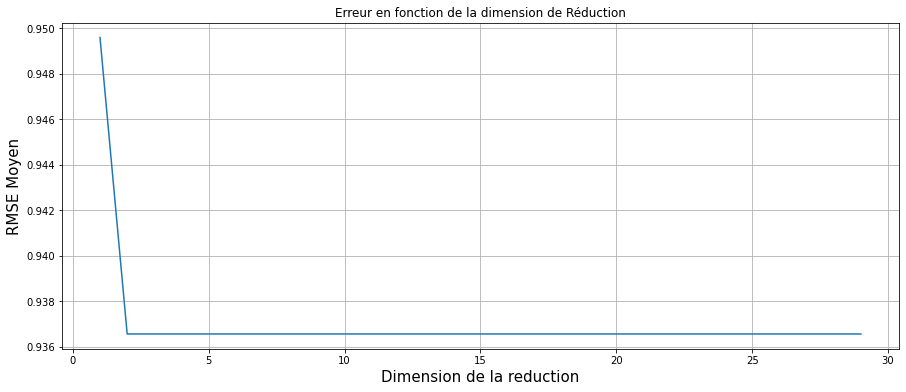

In [1574]:
plt.figure(figsize=(15,6))
plt.title('Erreur en fonction de la dimension de Réduction')
plt.xlabel('Dimension de la reduction',fontsize=15)
plt.ylabel('RMSE Moyen',fontsize=15)
plt.grid(True)
plt.plot(list(errors_component.keys()),list(errors_component.values()))

## Conclusion Question 3 : 

- L'approche par SVD est meilleure que l'approche basique de la question 1. Ici, on ne considère que les valeurs les plus importantes dans notre matrice utilisateur-item, ce qui permet d'ensuite faire la moyenne sur des éléments important. Les votes venant d'utilisateurs ou d'items peu pertinents sont rapidement supprimés pour optimiser la prédiction. 
- Afin de savoir quelle dimension nous choisissons, nous voyons qu'après 3 dimensions, la RMSE stagne. Afin d'éviter l'overfitting, nous choisirons le point de cassure, et donc *3 composantes*. 

## Question 4 

- Calcul de la matrice des similarites entre utilisateurs 

In [1575]:
def sim_matrix(user_item = user_item) : 
    ''' Return the correlation matrix '''
    corr = pd.DataFrame(np.corrcoef(user_item.fillna(0)))
    corr = corr.set_index([pd.Index(np.arange(1,user_item.shape[0]+1) )])
    corr.rename(columns = {i : i+1 for i in range(N_ITEMS-1)}, inplace = True )
    return corr 
    
    

- Calcul des notes moyens par cluster 

In [1576]:
def compute_grade_cluster(clusters , user_item = user_item ) : 
    ''' Compute the average score by item for each user with the given clusters '''
    
    # Matrix to return : the prediction with K-means
    user_pred = user_item.copy()
    
    for cluster in np.unique(clusters) : 
        index_user = np.where(clusters == cluster)[0]
        # Get the users of the cluster
        user_c = user_item.iloc[index_user]
        # Get the mean score for each item 
        mean_i = user_c.mean(axis = 0)
        user_pred.iloc[index_user, :] = mean_i    
    return user_pred
    

- Cross-validation

In [1577]:
def cross_validation_kmeans(N= votes.shape[0], n_clusters = 5 ,k = 5, user_item = user_item) : 
    ''' Compute the RMSE with K-cross-validation with K-means '''
    # Errors for every user 
    errors = np.zeros((user_item.shape[0],1))
    # Real user_item matrix
    user_item_true = fill_avg(  indexes = user_item.isnull() , user_item= user_item)
    # Get the indexes where there are not NaN values 
    indexes_not_nan = user_item.notnull()
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = False ).values())) : 
        # Copy the original user-item matrix 
        u_item = user_item_true.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:3]
        # Convert the test rating to NaN
        for m,j in zip(indexes_test['user.id'].values, indexes_test['item.id'].values) :            
            u_item.iloc[m-1,j-1] = np.nan
        # Get the similarity matrix 
        user_d = sim_matrix(user_item = u_item)
        # Fit the K-means algorithm
        kmeans = KMeans(n_clusters=n_clusters, random_state=77).fit(user_d)
        # Predict 
        prediction = compute_grade_cluster(kmeans.labels_)
        # Compute the RMSE 
        current_e = np.sqrt(np.mean((user_item_true[indexes_not_nan] -\
                                    prediction[indexes_not_nan])**2, axis = 1))
        errors= errors + current_e.values.reshape(-1,1)
    errors/=k        
    return pd.DataFrame(errors)
    

- Résumé des résultats 

In [1543]:
def get_results_kmeans(clusters = [5,10, 20, 40, 80]) : 
    ''' Get the RMSE for different size of clusters '''
    errors = {}
    for c in clusters : 
        err = cross_validation_kmeans(n_clusters = c ,k = 5, user_item = user_item)
        errors[c] = err.mean()[0]
    return errors 

In [1544]:
errors_clusters = get_results_kmeans()

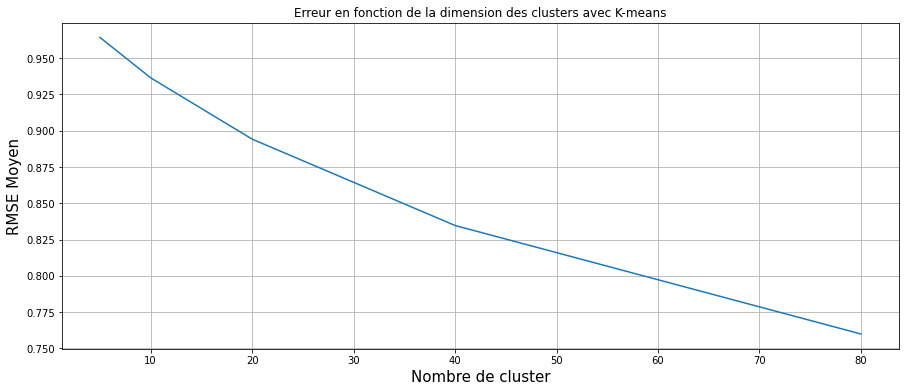

In [1547]:
plt.figure(figsize=(15,6))
plt.title('Erreur en fonction de la dimension des clusters avec K-means')
plt.xlabel('Nombre de cluster',fontsize=15)
plt.ylabel('RMSE Moyen',fontsize=15)
plt.grid(True)
plt.plot(list(errors_clusters.keys()),list(errors_clusters.values()))

In [1561]:
kmeans_min = np.min(list(errors_clusters.values()))
index_min = np.argmin(list(errors_clusters.values()))
kmeans_val = list(errors_clusters.keys())[index_min]

print('Meilleur résultat avec {} clusters pour K-means : {}'.format( kmeans_min, kmeans_val))

Meilleur résultat avec 0.7600038076414954 clusters pour K-means : 80


In [1578]:
errors_clusters

{5: 0.9642527846410422,
 10: 0.9364287655904363,
 20: 0.8942075662781775,
 40: 0.834725155902542,
 80: 0.7600038076414954}

## Conclusion Question 4 : 

- L'approche par K-means permet de regrouper ensemble les utilisateurs ayant des similarités dans leur choix d'items. De ce fait, chaque cluster a pour but de représenter de manière optimal chacun des utilisateurs de ce cluster. 
- Nous voyons que si nous prenons qu'une dimension, nous nous retrouvons avec le même score que celui obtenu lors de la question 1. Ensuite, plus nous augmentons le nombre de cluster, et meilleure est la représentation de ces clusters.
- Enfin, afin de choisir le bon nombre de clusters, nous préférons faire comme précédemment : prendre le point de cassure pour éviter l'overfitting. Ici, il semble qu'avec 40 clusters, nous obtenons une RMSE de 0.83, ce qui est préférable que d'avoir une RMSE de train plus élevé mais qui performe moins bien sur le testing test. Ainsi, avec 40 clusters, nous avons une RMSE bien meilleure que les méthodes précédentes. Cela signifie qu'en regroupant les utilisateurs dans 40 profils différents, un algorithme de recommendation de films peut prédire les notes des films en considérant les comportements des utilisateurs comme un comportement parmi 40 et optimiser la prédiction de notes de films. 